In [221]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [222]:
df_copy = pd.read_csv('df_clean.csv')
df_copy_all = pd.read_csv('df_copy_all.csv')

## Train and test data

In [223]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop('RainTomorrow', axis=1), 
                                                    df_copy['RainTomorrow'], random_state=42)

In [224]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90012, 112), (30004, 112), (90012,), (30004,))

## Standarisation

In [225]:
std_scaler = StandardScaler()

In [226]:
normalized_X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)

In [227]:
normalized_X_train.shape

(90012, 112)

In [228]:
normalized_X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

In [229]:
normalized_X_test.shape

(30004, 112)

## First basic Random Forest model

In [230]:
rf_classifier = RandomForestClassifier(n_estimators=5, criterion='gini', max_depth=5, random_state=42)

rf_classifier.fit(normalized_X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)

### crossvalidation

In [231]:
cross_val_score(rf_classifier, normalized_X_train, y_train, cv=10).mean()

0.8212127310350198

In [232]:
y_pred = rf_classifier.predict(normalized_X_test)

In [233]:
accuracy_score(y_test, y_pred)

0.8205905879216104

## RandomizedSearchCV for better parameters

In [234]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [2, 4, 6, 8, None],
              'min_samples_leaf': list(range(2,6)),
              'n_estimators': [10, 50, 100, 200]}

In [235]:
def grid_combination(grid):
    total_params = 1 
    for par in grid:
        total_params  = total_params * len(grid[par])
    return total_params

In [236]:
print(f'All combinations: {grid_combination(param_grid)}')

All combinations: 160


In [237]:
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, cv=5, n_iter=20, verbose=1, 
                                   scoring='accuracy',random_state=42)

random_search.fit(normalized_X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=5, n_estimators=5,
                                                    random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 4, 6, 8, None],
                                        'min_samples_leaf': [2, 3, 4, 5],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=42, scoring='accuracy', verbose=1)

In [238]:
random_search.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 2,
 'max_depth': None,
 'criterion': 'entropy'}

In [239]:
random_search.best_score_

0.8570635177192104

In [240]:
y_pred = random_search.best_estimator_.predict(normalized_X_test)

In [241]:
accuracy_score(y_test, y_pred)

0.8563858152246367

## GridSearchCV for best parameters

In [242]:
param_grid_2 = {'criterion': ['entropy'],
                'max_depth': [8, None],
                'min_samples_leaf': [2, 3],
                'n_estimators': [200, 220, 250]}

In [243]:
print(f'Liczba wszystkich kombinacji: {grid_combination(param_grid_2)}')

Liczba wszystkich kombinacji: 12


In [244]:
grid_search = GridSearchCV(rf_classifier, param_grid=param_grid_2, cv=5, verbose=1)

grid_search.fit(normalized_X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, n_estimators=5,
                                              random_state=42),
             param_grid={'criterion': ['entropy'], 'max_depth': [8, None],
                         'min_samples_leaf': [2, 3],
                         'n_estimators': [200, 220, 250]},
             verbose=1)

In [245]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'n_estimators': 250}

In [246]:
grid_search.best_score_

0.8574412282247297

In [247]:
y_pred = grid_search.best_estimator_.predict(normalized_X_test)

In [248]:
accuracy_score(y_test, y_pred)

0.856985735235302

### Adjusting max_features

In [249]:
rf_classifier_2 = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=2,
                                         n_estimators=250, max_features=8)

In [250]:
cross_val_score(rf_classifier_2, normalized_X_train, y_train, cv=5).mean()

0.8567524362352599

### Best model so far

In [251]:
rf_classifier_3 = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=2,
                                         n_estimators=250, max_features=10)

In [252]:
cross_val_score(rf_classifier_3, normalized_X_train, y_train, cv=5).mean()

0.8575523276086459

In [253]:
rf_classifier_3.fit(normalized_X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=10, min_samples_leaf=2,
                       n_estimators=250)

In [254]:
y_pred = rf_classifier_3.predict(normalized_X_test)

In [255]:
accuracy_score(y_test, y_pred)

0.857485668577523

## Filling missing values in sunshine, cloud9am/3pm

In [256]:
df_copy_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120016 entries, 0 to 120015
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       120016 non-null  object 
 1   MinTemp        120016 non-null  float64
 2   MaxTemp        120016 non-null  float64
 3   Rainfall       120016 non-null  float64
 4   Sunshine       65193 non-null   float64
 5   WindGustDir    120016 non-null  object 
 6   WindGustSpeed  120016 non-null  float64
 7   WindDir9am     120016 non-null  object 
 8   WindDir3pm     120016 non-null  object 
 9   WindSpeed9am   120016 non-null  float64
 10  WindSpeed3pm   120016 non-null  float64
 11  Humidity9am    120016 non-null  float64
 12  Humidity3pm    120016 non-null  float64
 13  Pressure9am    120016 non-null  float64
 14  Pressure3pm    120016 non-null  float64
 15  Cloud9am       74916 non-null   float64
 16  Cloud3pm       73581 non-null   float64
 17  Temp9am        120016 non-nul

In [257]:
sun_mean = np.mean(df_copy_all['Sunshine'])
cl9_mean = np.mean(df_copy_all['Cloud9am'])
cl3_mean = np.mean(df_copy_all['Cloud3pm'])

In [258]:
df_copy_all['Sunshine'] = df_copy_all['Sunshine'].fillna(sun_mean)
df_copy_all['Cloud9am'] = df_copy_all['Cloud9am'].fillna(cl9_mean)
df_copy_all['Cloud3pm'] = df_copy_all['Cloud3pm'].fillna(cl3_mean)

In [259]:
df_copy_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120016 entries, 0 to 120015
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       120016 non-null  object 
 1   MinTemp        120016 non-null  float64
 2   MaxTemp        120016 non-null  float64
 3   Rainfall       120016 non-null  float64
 4   Sunshine       120016 non-null  float64
 5   WindGustDir    120016 non-null  object 
 6   WindGustSpeed  120016 non-null  float64
 7   WindDir9am     120016 non-null  object 
 8   WindDir3pm     120016 non-null  object 
 9   WindSpeed9am   120016 non-null  float64
 10  WindSpeed3pm   120016 non-null  float64
 11  Humidity9am    120016 non-null  float64
 12  Humidity3pm    120016 non-null  float64
 13  Pressure9am    120016 non-null  float64
 14  Pressure3pm    120016 non-null  float64
 15  Cloud9am       120016 non-null  float64
 16  Cloud3pm       120016 non-null  float64
 17  Temp9am        120016 non-nul

In [260]:
df_copy_all['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

### Label encoding

In [261]:
le = LabelEncoder()

In [262]:
le.fit(df_copy_all['RainTomorrow'])

LabelEncoder()

In [263]:
df_copy_all['RainTomorrow'] = le.transform(df_copy_all['RainTomorrow'])

In [264]:
df_copy_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120016 entries, 0 to 120015
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       120016 non-null  object 
 1   MinTemp        120016 non-null  float64
 2   MaxTemp        120016 non-null  float64
 3   Rainfall       120016 non-null  float64
 4   Sunshine       120016 non-null  float64
 5   WindGustDir    120016 non-null  object 
 6   WindGustSpeed  120016 non-null  float64
 7   WindDir9am     120016 non-null  object 
 8   WindDir3pm     120016 non-null  object 
 9   WindSpeed9am   120016 non-null  float64
 10  WindSpeed3pm   120016 non-null  float64
 11  Humidity9am    120016 non-null  float64
 12  Humidity3pm    120016 non-null  float64
 13  Pressure9am    120016 non-null  float64
 14  Pressure3pm    120016 non-null  float64
 15  Cloud9am       120016 non-null  float64
 16  Cloud3pm       120016 non-null  float64
 17  Temp9am        120016 non-nul

## Correlation

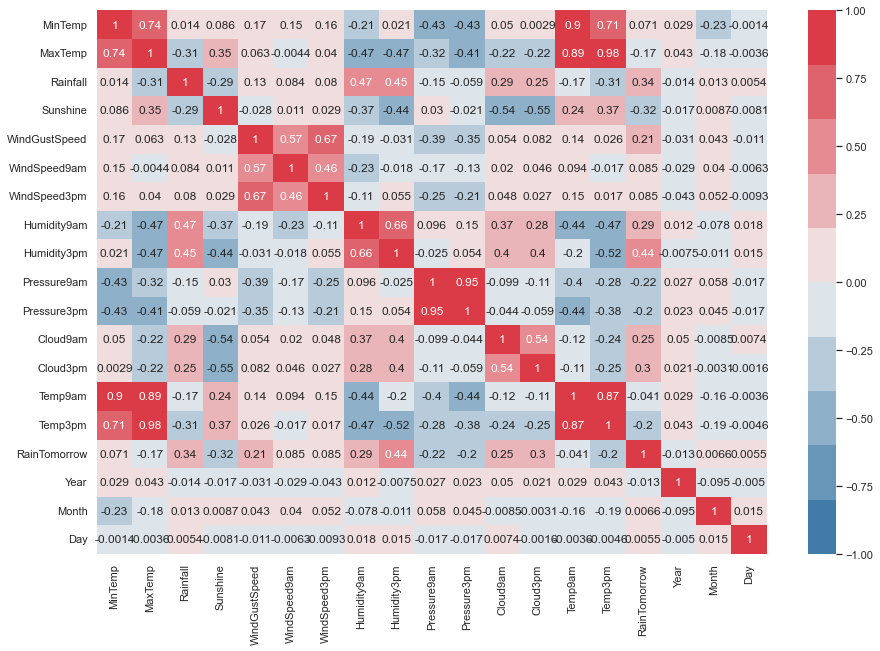

In [265]:
cM = df_copy_all.corr(method='spearman')
sns.set(rc={'figure.figsize': (15,10)})
color_map = sns.diverging_palette(240,10,n=10)
sns.heatmap(cM, vmin=-1., vmax=1., cmap=color_map, annot=True);

## Categorical data 

In [266]:
df_copy_all = pd.get_dummies(df_copy_all)

In [267]:
df_copy_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120016 entries, 0 to 120015
Columns: 116 entries, MinTemp to RainToday_Yes
dtypes: float64(15), int32(1), int64(3), uint8(97)
memory usage: 28.0 MB


## Train and test data

In [268]:
X_train, X_test, y_train, y_test = train_test_split(df_copy_all.drop('RainTomorrow', axis=1), df_copy_all['RainTomorrow'],
                                                   random_state=42)

In [269]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90012, 115), (30004, 115), (90012,), (30004,))

## Standarisation

In [270]:
std_scaler = StandardScaler()
normalized_X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)

In [271]:
normalized_X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

## Basic model on this data

In [272]:
rf_classifier = RandomForestClassifier(n_estimators=5, criterion='gini', max_depth=5, random_state=42)

rf_classifier.fit(normalized_X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)

In [273]:
cross_val_score(rf_classifier, normalized_X_train, y_train, cv=10).mean()

0.8356996362768057

## RandomizedSearchCV for better parameters

In [274]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [4, 6, 8, None],
              'min_samples_leaf': [4, 6, 8],
              'n_estimators': [100, 150, 200]}

In [275]:
print(f'Liczba wszystkich kombinacji: {grid_combination(param_grid)}')

Liczba wszystkich kombinacji: 72


In [276]:
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, cv=5, n_iter=15, verbose=2, 
                                   scoring='accuracy',random_state=42)

random_search.fit(normalized_X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.3s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.3s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.5s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.8s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   6.7s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=  11.0s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=  11.2s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=  12.4s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=  11.2s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimator

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=5, n_estimators=5,
                                                    random_state=42),
                   n_iter=15,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [4, 6, 8, None],
                                        'min_samples_leaf': [4, 6, 8],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, scoring='accuracy', verbose=2)

In [277]:
random_search.best_score_

0.85784117082586

In [278]:
random_search.best_params_

{'n_estimators': 150,
 'min_samples_leaf': 4,
 'max_depth': None,
 'criterion': 'entropy'}

In [279]:
y_pred = random_search.best_estimator_.predict(normalized_X_test)

In [280]:
accuracy_score(y_test, y_pred)

0.8570857219037462

## Best model has 85.7 % accuracy

In [281]:
best_model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=4, n_estimators=150,
                                   random_state=42)

best_model.fit(normalized_X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       n_estimators=150, random_state=42)

In [282]:
y_pred = best_model.predict(normalized_X_test)

In [283]:
accuracy_score(y_test, y_pred)

0.8570857219037462

## Model not using all features, only most correlated ones

In [284]:
features_test = ['MaxTemp', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
                 'Pressure3pm', 'Rainfall', 'Cloud9am', 'Cloud3pm', 'Temp3pm']

In [285]:
random_search_test = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, cv=5, n_iter=15, verbose=2, 
                                   scoring='accuracy',random_state=42)

random_search_test.fit(normalized_X_train[features_test],y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.2s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.3s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.2s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.2s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, n_estimators=150; total time=   4.2s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=   9.8s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=   9.8s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=   9.9s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimators=200; total time=   9.9s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, n_estimator

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=5, n_estimators=5,
                                                    random_state=42),
                   n_iter=15,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [4, 6, 8, None],
                                        'min_samples_leaf': [4, 6, 8],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, scoring='accuracy', verbose=2)

In [286]:
random_search_test.best_params_

{'n_estimators': 150,
 'min_samples_leaf': 4,
 'max_depth': None,
 'criterion': 'entropy'}

In [287]:
random_search_test.best_score_

0.8559081041209275

In [288]:
y_pred_test_search = random_search_test.best_estimator_.predict(normalized_X_test[features_test])

In [289]:
accuracy_score(y_test, y_pred_test_search)

0.8566857752299694

## 85.7 % accuracy score for this model